In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn import preprocessing
import warnings
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import math
import numpy
import random
import scipy.special as special
import tqdm
import gc
import pickle
import xgboost as xgb

In [2]:
def feat_select(train, test):
  
    features = train.drop(['is_trade', 'time', 'context_timestamp','user_id','context_id','instance_id','item_id','shop_id','item_brand_id'], axis=1).columns.tolist() #,'item_property_list','predict_category_property'

    target = ['is_trade']

    return features, target

In [3]:
path = '/Users/apple/Desktop/data/new/'
data = pd.read_csv(path+"rate_final_data_12-01-11-28.csv")
train = pd.read_csv(path+"train_day7.csv")
train = train[['instance_id']]
train =pd.merge(train, data, how='left', on='instance_id')
train

,instance_id,item_id,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,...,i_day_diffTime_first,i_day_diffTime_last,b_day_diffTime_first,b_day_diffTime_last,s_day_diffTime_first,s_day_diffTime_last,user_id_lasttime_diff,item_id_lasttime_diff,user_id_nexttime_diff,item_id_nexttime_diff
0,8188426453186991303,17515,1463,2,7,11,11,15,251252,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,3055029702117669227,35386,4142,136,8,11,10,17,97041,0,...,-1208,-1856,-1,-1,-1,-1,-1,3315,-1,-3315
2,1878633151450315841,49343,9864,179,5,13,12,19,333427,0,...,-24840,-6243,-1,-1,-1,-1,-1,2065,-1,-2065
3,5459525893214430925,35423,822,104,7,12,13,19,619491,0,...,-7977,-28625,-1,-1,-1,-1,-1,14848,-1,-14848
4,510266929751254521,47335,7945,194,6,11,12,16,619592,0,...,-3982,974,-1,-1,-1,-1,-1,-33147,-1,33147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86221,7094392840348381260,26570,9001,136,7,8,8,16,77803,0,...,561,-28873,-1,-1,-1,-1,-1,33487,-1,-33487
86222,8547491895146613484,35459,10369,106,7,12,15,18,419863,1,...,-667,11697,-1,-1,-1,-1,-1,-7620,-1,7620
86223,306961936423539992,43770,9001,191,9,11,11,20,647722,1,...,-16463,7837,-1,-1,-1,-1,-1,3809,-1,-3809
86224,2587524758236247792,13877,5242,151,8,11,11,18,283765,0,...,13907,-14178,-1,-1,-1,-1,70,9051,-70,-9051


In [4]:
test = pd.read_csv(path+"test_day7.csv")
test = test[['instance_id']]
test = pd.merge(test, data, how='left', on='instance_id')
test

,instance_id,item_id,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,user_gender_id,...,i_day_diffTime_first,i_day_diffTime_last,b_day_diffTime_first,b_day_diffTime_last,s_day_diffTime_first,s_day_diffTime_last,user_id_lasttime_diff,item_id_lasttime_diff,user_id_nexttime_diff,item_id_nexttime_diff
0,4048992542748216323,48186,3074,159,7,13,15,18,660604,0,...,-8656,-1135,-1,-1,-1,-1,745,3316,-745,-3316
1,8989941032636729130,36887,6415,20,8,13,13,18,16800,0,...,0,-22120,-1,-1,-1,-1,197,-1,-197,-1
2,5406763230001560145,46862,9001,2,5,11,11,19,660560,0,...,39956,-15048,-1,-1,-1,-1,-1,7594,-1,-7594
3,5054876038445746595,17844,8779,26,7,14,13,18,436842,0,...,-36250,-3701,-1,-1,-1,-1,-1,-37316,-1,37316
4,2075792583647739333,4559,3652,124,7,11,12,17,131400,1,...,-15556,29152,-1,-1,-1,-1,-1,-22443,-1,22443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21552,8425273622584226983,70,8892,151,7,8,10,15,314153,0,...,-16973,5172,-1,-1,-1,-1,-1,-5019,-1,5019
21553,5425541367121665940,48677,5152,129,6,14,16,19,317850,0,...,5781,35580,-1,-1,-1,-1,-1,-33549,-1,33549
21554,7678669209753772508,26422,7706,99,6,11,12,16,84022,0,...,-10009,-23942,-1,-1,-1,-1,-1,2315,-1,-2315
21555,4319564584169909197,19399,9001,136,6,14,14,20,235139,0,...,-4934,3772,-1,-1,-1,-1,-1,2944,-1,-2944


In [5]:
train = train.drop('day_y', axis=1)
train = train.drop('is_trade_y', axis=1)
train = train.rename(columns={'day_x': 'day'})
train = train.rename(columns={'is_trade_x': 'is_trade'})

In [6]:
test = test.drop('day_y', axis=1)
test = test.drop('is_trade_y', axis=1)
test = test.rename(columns={'day_x': 'day'})
test = test.rename(columns={'is_trade_x': 'is_trade'})

In [7]:
from xgboost import plot_importance

def xgbCV(train, test):
    
    features, target = feat_select(train, test)
    
    X = train[features]
    y = train[target]
    X_tes = test[features]
    y_tes = test[target]

    print('Training XGB model...')
    X_train_set = xgb.DMatrix(X, label=y, missing=np.nan)
    X_validate_set = xgb.DMatrix(X_tes, label=y_tes, missing=np.nan)
    watchlist = [(X_train_set, 'train'), (X_validate_set, 'eval')]
    params = {'max_depth':7,
              'nthread': 25,
              'eta': 0.01,
            #   'eval_metric': 'logloss',
              'objective': 'binary:logistic',
              'subsample': 0.85,
              'colsample_bytree': 0.85,
              'silent': 1,
              'seed': 0,
              'min_child_weight': 6
              #'scale_pos_weight':0.5
              }
    gbm = xgb.train(params, X_train_set, evals=watchlist, early_stopping_rounds=50) #, num_boost_round=3000
    plot_importance(gbm)

    best_iter_num = gbm.best_iteration
    return best_iter_num,gbm


Training XGB model...
[11:33:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-logloss:0.68494	eval-logloss:0.68495
[1]	train-logloss:0.67688	eval-logloss:0.67690
[2]	train-logloss:0.66898	eval-logloss:0.66902
[3]	train-logloss:0.66123	eval-logloss:0.66128
[4]	train-logloss:0.65363	eval-logloss:0.65369
[5]	train-logloss:0.64618	eval-logloss:0.64625
[6]	train-logloss:0.63887	eval-logloss:0.63895
[7]	train-logloss:0.63170	eval-logloss:0.63180
[8]	train-logloss:0.62466	eval-logloss:0.62477
[9]	train-logloss:0.61774	eval-logloss:0.61787


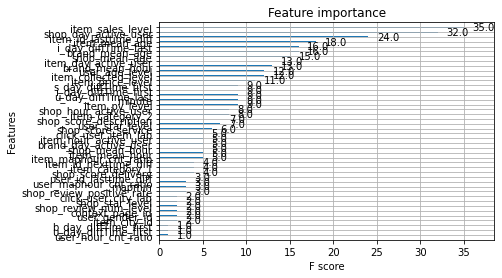

In [8]:
best_iter,gbm = xgbCV(train, test)

In [9]:
best_iter

9

In [10]:
type(gbm)

xgboost.core.Booster

In [11]:
import operator
importance = gbm.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1),reverse=True)
pd.DataFrame(importance).to_csv(path+'xgb_feat_imp_day7_10w.csv',index=False)